# Process data

Cargamos las librerías que deseamos usar:

In [1]:
import missingno as msno

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt # Para dibujar
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter # Para cambiar las etiquetas de las gráficas

from cycler import cycler # Para elegir ciclos de colores

In [3]:
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['lines.antialiased'] = True

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 25

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'both'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

mpl.rcParams['grid.alpha'] = 0.4

mpl.rcParams['axes.prop_cycle'] = cycler(color = ['r', 'orangered', 'gold', 'forestgreen', 'royalblue', 'rebeccapurple'])


mpl.rcParams['figure.figsize'] = (4,8/3)
mpl.rcParams['figure.subplot.wspace'] = 0.2
mpl.rcParams['figure.subplot.hspace'] = 0.2
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams['figure.titlesize'] = 'large'

mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams['legend.fontsize'] = 'medium'

Cargamos los metadatos del conjunto de archivos (contenidos en `metadata.xlsx`), i.e. variables de cada archivo, unidades, fuentes, etc.

In [4]:
data01 = 'data/data_1/'
filename = 'metadata.xlsx'
output_file = 'VPQ.csv'
fig_dir = '../CIC-doc/doc/figures/'

index = pd.read_excel(data01 + filename)

In [5]:
index

,TAG,Description,Unit,Type,Comments,Source,Explotación,Código Explotación,Nº Estación,Sistema
0,GES450100001N00001,Lect. Horaria Contador Sector Arroyuelo,m³,Analogico,NaN,Madridejos - Sector Arroyuelo y Ayuntamiento,Madridejos,4501,1,PCWIN - Madridejos
1,GES450100001N00005,Presión Instantánea Sector Arroyuelo,Kg/cm²,Analogico,NaN,Madridejos - Sector Arroyuelo y Ayuntamiento,Madridejos,4501,1,PCWIN - Madridejos
2,GES450100001N00015,Q Inst. Sector Arroyuelo,m³/h,Analogico,NaN,Madridejos - Sector Arroyuelo y Ayuntamiento,Madridejos,4501,1,PCWIN - Madridejos
3,GES450100001N00019,Lect. Diaria Contador Sector Arroyuelo,m³,Analogico,NaN,Madridejos - Sector Arroyuelo y Ayuntamiento,Madridejos,4501,1,PCWIN - Madridejos
4,GES450100001N00023,Producción Diaria Sector Arroyuelo,m³,Analogico,NaN,Madridejos - Sector Arroyuelo y Ayuntamiento,Madridejos,4501,1,PCWIN - Madridejos
5,GES450100001N00027,Q Mín. Diario Sector Arroyuelo,m³/h,Analogico,NaN,Madridejos - Sector Arroyuelo y Ayuntamiento,Madridejos,4501,1,PCWIN - Madridejos
6,GES450100001N00031,Q Máx. Diario Sector Arroyuelo,m³/h,Analogico,NaN,Madridejos - Sector Arroyuelo y Ayuntamiento,Madridejos,4501,1,PCWIN - Madridejos
7,GES450100001N00035,Q Noche Diario Sector Arroyuelo,m³/h,Analogico,NaN,Madridejos - Sector Arroyuelo y Ayuntamiento,Madridejos,4501,1,PCWIN - Madridejos


Cambiamos los nombres de las variables de volumen, caudal y presión para mayor claridad en el código:

In [6]:
translator = {
    'Presión Instantánea Sector Arroyuelo' : 'P',
    'Q Inst. Sector Arroyuelo' : 'Q',
    'Lect. Horaria Contador Sector Arroyuelo' : 'V'
}

Transformamos los archivos `csv` en tablas pandas. Esta librería ofrece muchas funcionalidades para trabajar con fechas.

In [7]:
tt = []
for i, entry in index.iterrows():
    print('Leyendo archivo:', entry['TAG'] + '.csv')
    desc = entry['Description']
    table = pd.read_csv(data01 + entry['TAG'] + '.csv',
                sep = ';',
                header = None,
                names = ['timestamp', desc, 'Cod_' + desc],
                index_col = False,
                skiprows = 7,
                infer_datetime_format = True,
                decimal = ','
                ).iloc[:,:-1]
    table['timestamp'] = pd.to_datetime(table['timestamp'], format = '%d/%m/%Y %H:%M:%S.%f')
    table.set_index(keys = 'timestamp', inplace = True)
    tt.append(table)

Leyendo archivo: GES450100001N00001.csv
Leyendo archivo: GES450100001N00005.csv
Leyendo archivo: GES450100001N00015.csv
Leyendo archivo: GES450100001N00019.csv
Leyendo archivo: GES450100001N00023.csv
Leyendo archivo: GES450100001N00027.csv
Leyendo archivo: GES450100001N00031.csv
Leyendo archivo: GES450100001N00035.csv


Creamos un índices con todas las variables disponibles con las unidades inclusive.

In [8]:
dates = pd.date_range(start = tt[0].index.min(), end = tt[0].index.max(), freq = '15T')
dates.name = 'timestamp'
data = pd.DataFrame(index = dates)

for table in tt[1:]:
    data = data.merge(table, how = 'outer', left_index = True, right_index = True)
    
data.rename(columns = translator, inplace = True)
micolumns = pd.MultiIndex.from_tuples(list(zip(data.columns.tolist(), index['Unit'])),
                                      names=['variable', 'unit'])


data.set_axis(micolumns, axis = 1, inplace = True)

In [9]:
data.head(3)

variable,P,Q,Lect. Diaria Contador Sector Arroyuelo,Producción Diaria Sector Arroyuelo,Q Mín. Diario Sector Arroyuelo,Q Máx. Diario Sector Arroyuelo,Q Noche Diario Sector Arroyuelo
unit,m³,Kg/cm²,m³/h,m³,m³,m³/h,m³/h
timestamp,,,,,,,
2014-03-27 08:15:00,3.524071,17.92,NaN,NaN,NaN,NaN,NaN
2014-03-27 08:30:00,3.485924,22.08,NaN,NaN,NaN,NaN,NaN
2014-03-27 08:45:00,3.485924,23.16,NaN,NaN,NaN,NaN,NaN


---

## Comrpobación de los registros datados

Para entender mejor los datos proporcionados, procedemos con el estudio de los datados del registro:

In [10]:
df = tt[1].reset_index(level=0)

In [11]:
print('Fecha inicial:\t',df['timestamp'].min())
print('Fecha final:\t', df['timestamp'].max())

Fecha inicial:	 2014-03-27 08:15:00
Fecha final:	 2019-11-08 07:00:00


Buscamos si existe cambios de hora de verano en los datos:

In [12]:
dates_spring = [
    '2014/03/30 01:30', '2014/03/30 03:00',
    '2015/03/29 01:30', '2015/03/29 03:00',
    '2016/03/27 01:30', '2016/03/27 03:00',
    '2017/03/26 01:30', '2017/03/26 03:00',
    '2018/03/25 01:30', '2018/03/25 03:00',
    '2019/03/31 01:30', '2019/03/31 03:00'
]

Mostramos los cambios de hora del mes de marzo, donde se añade una hora al reloj:

In [13]:
print('##############################')

for i in np.arange(0, len(dates_spring), 2):
    print(i/2)
    print(
    df['timestamp'][(df['timestamp'] >= dates_spring[i] ) &
    (df['timestamp'] <= dates_spring[i+1] )].to_string()
    )
    print('##############################')

##############################
0.0
261   2014-03-30 01:30:00
262   2014-03-30 01:45:00
263   2014-03-30 03:00:00
##############################
1.0
34054   2015-03-29 01:30:00
34055   2015-03-29 01:45:00
34056   2015-03-29 03:00:00
##############################
2.0
62815   2016-03-27 01:30:00
62816   2016-03-27 01:45:00
62817   2016-03-27 03:00:00
##############################
3.0
95506   2017-03-26 01:30:00
95507   2017-03-26 01:45:00
95508   2017-03-26 03:00:00
##############################
4.0
126835   2018-03-25 01:30:00
126836   2018-03-25 01:45:00
126837   2018-03-25 03:00:00
##############################
5.0
162442   2019-03-31 01:30:00
162443   2019-03-31 01:45:00
162444   2019-03-31 03:00:00
##############################


Encontramos los saltos de cambio de hora de marzo. Podemos hacer un proceso similar para el cambio de hora de otoño:

In [14]:
dates_fall = [
    '2014/10/26 01:30', '2014/10/26 03:00',
    '2015/10/25 01:30', '2015/10/25 03:00',
    '2016/10/30 01:30', '2016/10/30 03:00',
    '2017/10/29 01:30', '2017/10/29 03:00',
    '2018/10/28 01:30', '2018/10/28 03:00',
    '2019/10/27 01:30', '2019/10/27 03:00'
]

In [15]:
print('##############################')

for i in np.arange(0, len(dates_fall), 2):
    print(int(i/2) + 2014)
    print(
   df[(df['timestamp'] >= dates_fall[i] ) &
    (df['timestamp'] <= dates_fall[i+1] )].to_string()
    )
    print('##############################')

##############################
2014
                timestamp  Presión Instantánea Sector Arroyuelo
20088 2014-10-26 01:30:00                              3.587701
20089 2014-10-26 01:45:00                              3.613184
20090 2014-10-26 02:00:00                              3.613184
20091 2014-10-26 02:15:00                              3.625849
20092 2014-10-26 02:30:00                              3.625849
20093 2014-10-26 02:45:00                              3.613184
20094 2014-10-26 02:00:00                              3.638666
20095 2014-10-26 02:15:00                              3.651331
20096 2014-10-26 02:30:00                              3.625849
20097 2014-10-26 02:45:00                              3.625849
20098 2014-10-26 03:00:00                              3.638666
##############################
2015
                timestamp  Presión Instantánea Sector Arroyuelo
48436 2015-10-25 01:30:00                              3.663996
48437 2015-10-25 01:45:00       

Para este caso, vemos que sólo en 2014 y en 2015 se cambia una hora menos el reloj. Esto nos puede llevar a pensar que durante el periodo de tiempo de recogida de los datos, el sistema para datarlos, cambió su zona horaria a una que no tenga horario de verano. Sin embargo, podemos saber que esto no es cierto cuando consideramos que los cambios de hora de primavera sí han tenido lugar durante el periodo completo de recogida de datos.

Comprobamos que no aparecen fechas duplicadas en todo el dataset:

In [16]:
df['timestamp'][
    df['timestamp'].duplicated(keep = False)
]

20090   2014-10-26 02:00:00
20091   2014-10-26 02:15:00
20092   2014-10-26 02:30:00
20093   2014-10-26 02:45:00
20094   2014-10-26 02:00:00
20095   2014-10-26 02:15:00
20096   2014-10-26 02:30:00
20097   2014-10-26 02:45:00
48438   2015-10-25 02:00:00
48439   2015-10-25 02:15:00
48440   2015-10-25 02:30:00
48441   2015-10-25 02:45:00
48442   2015-10-25 02:00:00
48443   2015-10-25 02:15:00
48444   2015-10-25 02:30:00
48445   2015-10-25 02:45:00
Name: timestamp, dtype: datetime64[ns]

Sólo encontramos duplicados de los cambios de hora del mes de octubre de 2014 y 2015. Esto sugiere que el cambio de hora no se ha producido (incluso en una fecho o hora distinta a la establecida), o los datos de una hora no están registrados.

---

# Completitud de los datos

Comprobemos visualmente la falta de datos que se debe a la falta de registros durante el periodo de recopilación de datos.

In [17]:
df['diff'] = df['timestamp'].diff()/np.timedelta64(1,'h')
df['diff'] += -0.25
df.at[df['diff'] > 3.0, 'diff'] = np.NaN

En las siguientes gráficas representamos los intervalos de tiempo de los registros. Los puntos por encima del eje de coordenadas corresponden a saltos positivos de tiempo superiores al salto típico entre dos puntos de tiempo contiguos (15 min). Por debajo del eje, corresponden con saltos negativos.

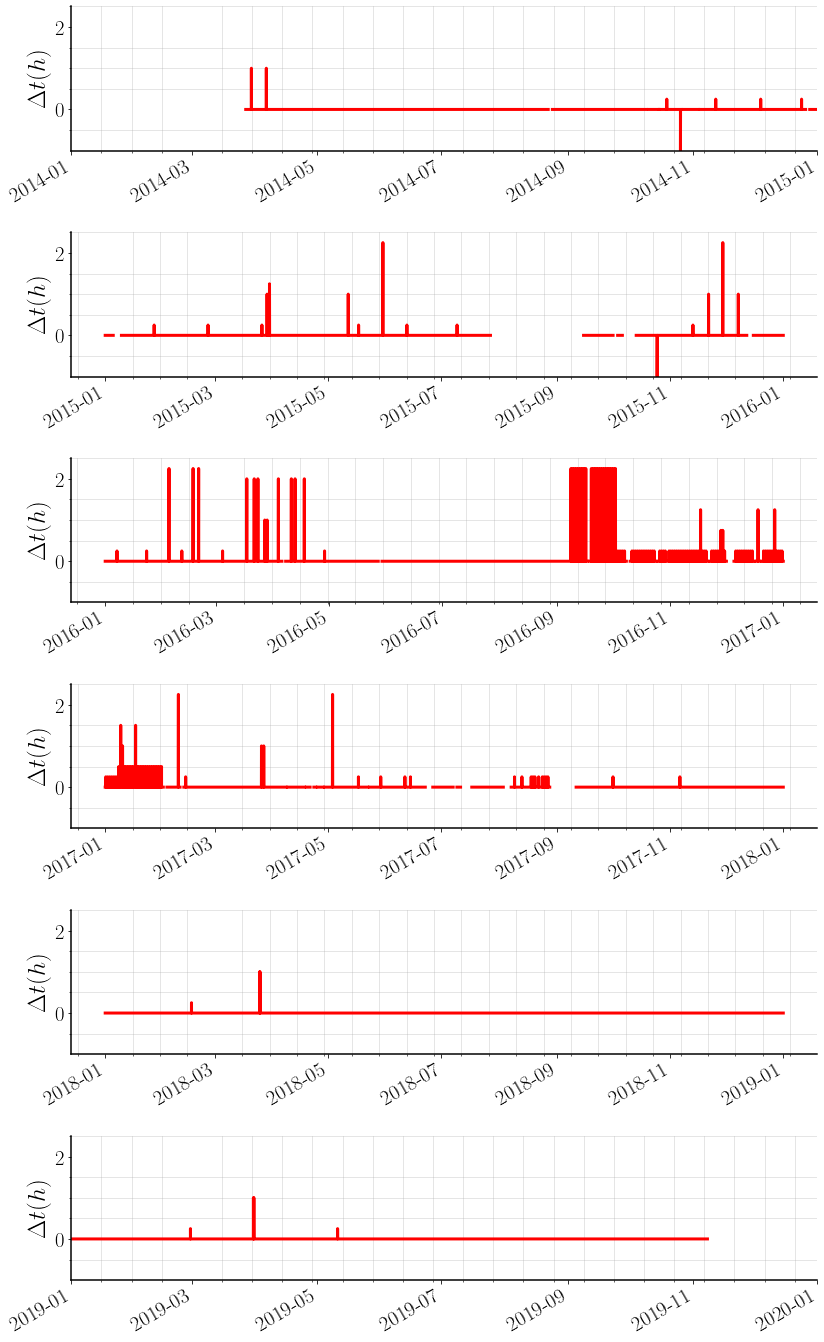

In [38]:
fig, axs = plt.subplots(6,1, figsize = (12,8/5*12))

for j, i in enumerate(np.arange(2014,2020)):
    df[
        (str(i) <= df['timestamp']) &
        (df['timestamp'] < str(i+1))
    ].plot(x = 'timestamp', y = 'diff', ylim = (-1,2.5), ax = axs[j])
    axs[j].set_ylabel(r'$\Delta t (h)$')
    axs[j].set_xlabel('')
#     axs[j].set_title(i)
    axs[j].grid()
    axs[j].get_legend().remove()

axs[0].set_xlim(('2014-01-01', '2015-01-01'))
axs[-1].set_xlim(('2019-01-01', '2020-01-01'))

plt.show()
fig.savefig(fig_dir + "faltan_fechas.pdf")

Encontramos que existen sólo dos saltos negativos, uno en 2014 y otro en 2015 correspondientes  a los cambios de hora en octubre de esos años. Observamos que ningún otro salto negativo se ha dado y por lo tanto, no podemos determinar con claridad cuando el reloj decidió cambiar al horario de invierno. Algunos de los intervalos son muy grandes y hubieran complicado la visualización del resto, los intervalos superiores a 3 horas han sido omitidos. Se pueden seguir observando cuando no aparecen datos en segmentos del eje de coordenadas.

Intentamos visualizar mejor la distribución de los datos. Obsérvese en la siguiente figura los espacios sin registros (regiones blancas):

C:\Users\jalonso\Anaconda3\envs\mountain\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


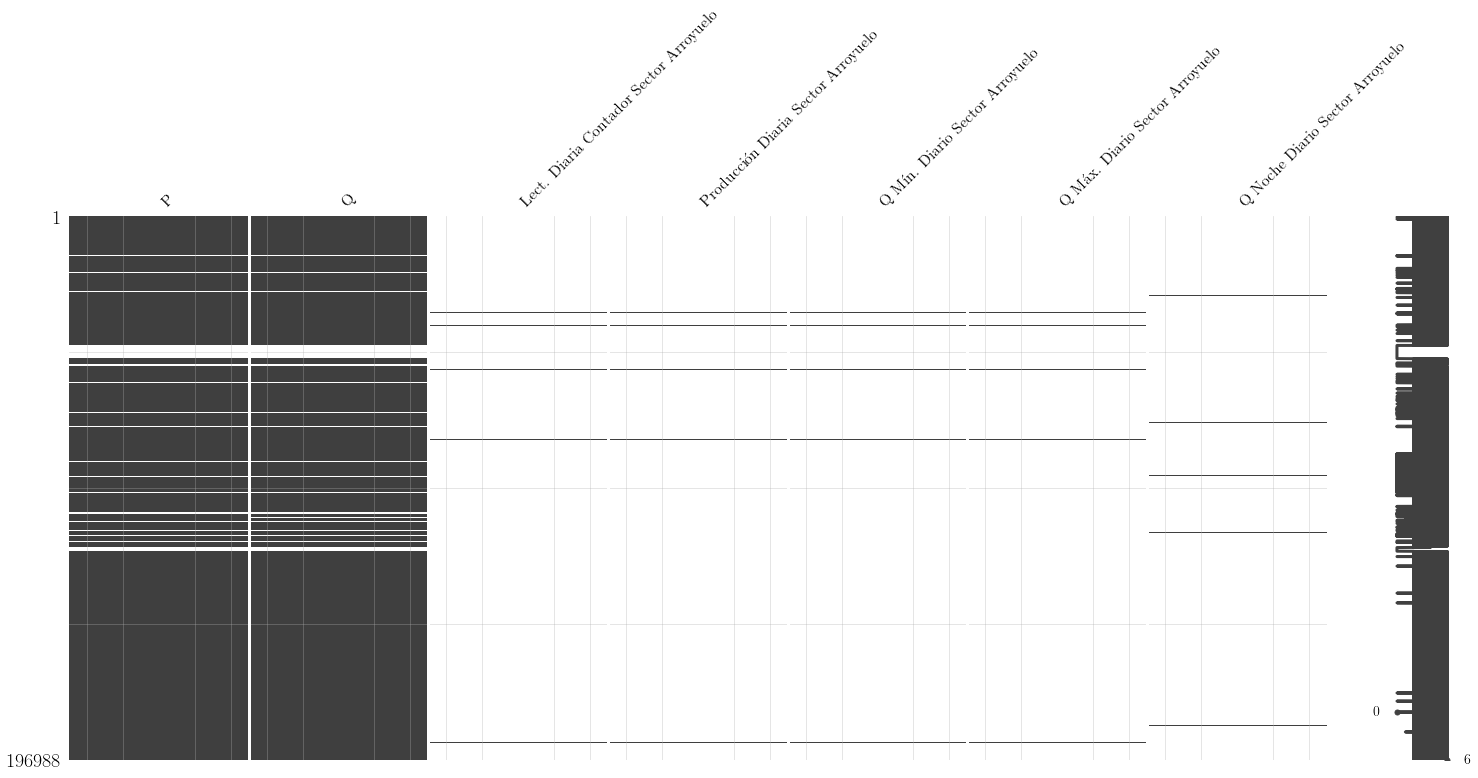

In [19]:
%matplotlib inline

dr = pd.date_range(
start = df['timestamp'].min(),
end = df['timestamp'].max(),
freq = '15T')

# X = data.drop_duplicates(subset = 'timestamp', keep = 'last').set_index('timestamp').reindex(dr, fill_value = np.NaN)
X = data.reset_index(level=0).droplevel('unit', axis=1).drop_duplicates(subset = 'timestamp', keep = 'last').set_index('timestamp').reindex(dr, fill_value = np.NaN)
msno.matrix(X)

Observamos tanto en la figura superior como en la inferior que las variables `Pi` y `Qi` son muy abundantes aunque existen fechas donde no hay datos. El resto de variables son diarias, al contrario que la presión y el caudal que se recogen cada 15 minutos. Representamos estas variables por sí solas y encontramos que tienen la misma frecuencia y no se aprecian saltos grandes en el tiempo.

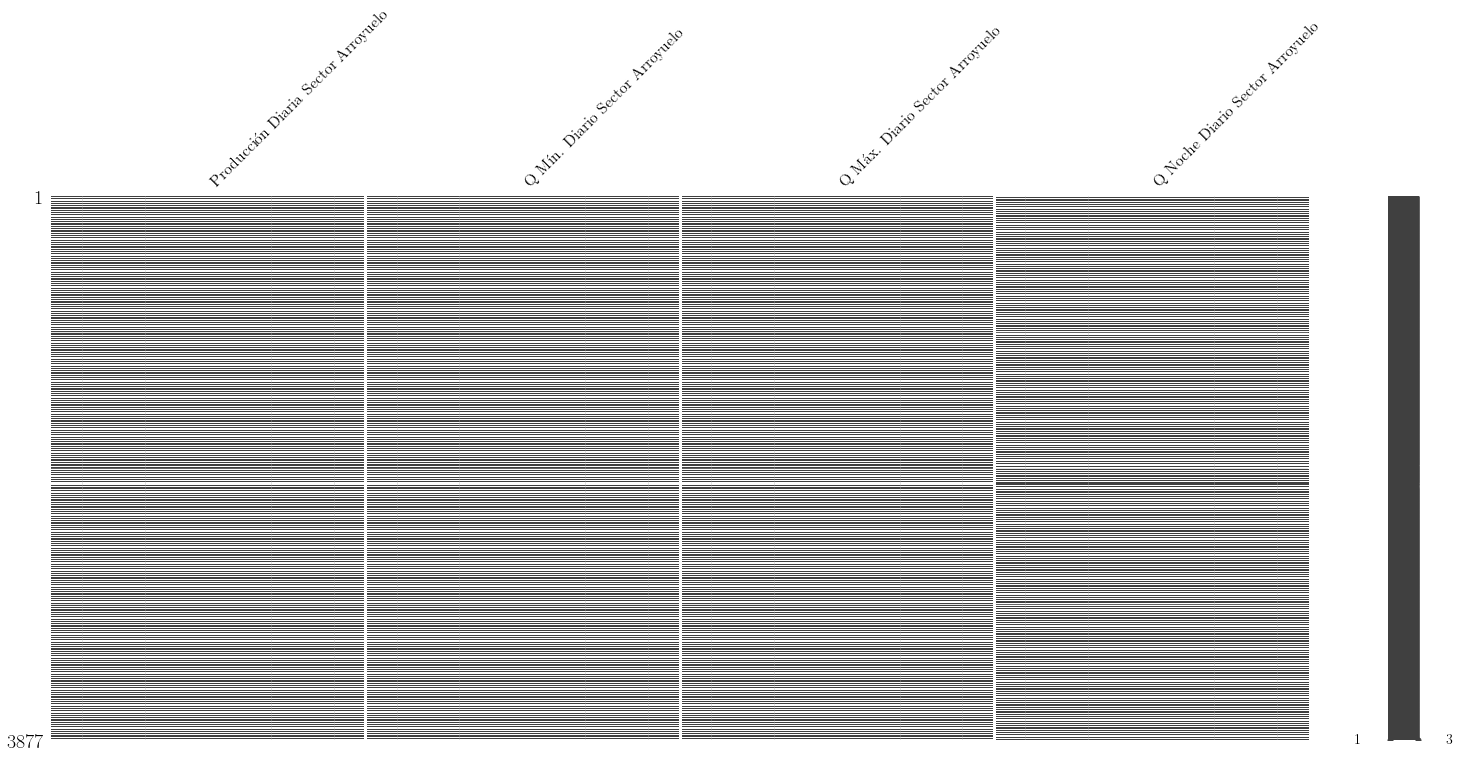

In [20]:
msno.matrix(X.iloc[:,3:].dropna(how = 'all'))

En la próxima figura representamos la cantidad relativa de puntos temporales que no están registrados por año. Encontramos el 2015 es el año en que se perdieron más datos. Por otro lado, 2018 y 2019 son los años con muy poca falta de datos (menos del 1%). En el próximo anexo veremos que todos los datos de 2018 y 2019 son 0, lo que explica que falten pocos datos.

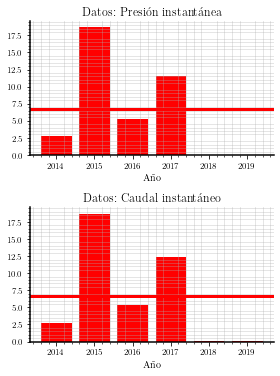

In [22]:
yy = []
missing_pi = []
missing_qi = []

for i in np.arange(2014,2020):
    yy.append(i)
    X_temp_pi = X[str(i)].loc[:, 'P']
    X_temp_qi = X[str(i)].loc[:, 'Q']
    missing_pi.append(X_temp_pi.isnull().sum()/X_temp_pi.shape[0])
    missing_qi.append(X_temp_qi.isnull().sum()/X_temp_qi.shape[0])
    
    
def percentages(x, pos):
    'The two args are the value and tick position'
    return '%1.1f%%' % (x * 100)

formatter = FuncFormatter(percentages)
    
fig, axs = plt.subplots(2,1, figsize = (4,8/3*2))

for ax, bars, title in zip(axs, [missing_pi, missing_qi], ['Presión instantánea', 'Caudal instantáneo']):

    ax.bar(yy, bars)
    ax.yaxis.set_major_formatter(formatter)
    ax.axhline(X.iloc[:,0].isnull().sum()/X.shape[0], color = 'r')
    ax.grid()


    ax.set_xlabel('Año')
    ax.set_title('Datos: ' + title)
plt.show()

---

# Extracción de las secuencias temporales

Procedemos a interpolar los datos para garantizar que los cambios de hora no afecten al número de horas en esos días. 

Comenzamos por crear una variable `data` que agrupe de nuevo todas las variables en una misma tabla, la diferencia ahora es la línea:
```python
data = data.merge(table.groupby(pd.Grouper(freq = '15min', label = 'left')).mean(),
                  how = 'outer', left_index = True, right_index = True)
```
 donde llamamos al método `groupby` para agrupar aquellos datos con el mismo tiempo y hallar la media de ambas para asignar un valor aproximado.

In [23]:
# Muestra en pantalla los datos sobre las que se hará media aritmética
def gg(x):
    if x.shape[0] > 1:
        print(x)
    return x.mean()

In [24]:
dates = pd.date_range(start = tt[0].index.min(), end = tt[0].index.max(), freq = '15T')
dates.name = 'timestamp'
data = pd.DataFrame(index = dates)

for table in tt[0:]:
    data = data.merge(table.groupby(pd.Grouper(freq = '15min', label = 'left')).agg(gg),
                      how = 'outer', left_index = True, right_index = True)
    
data.rename(columns = translator, inplace = True)
micolumns = pd.MultiIndex.from_tuples(list(zip(data.columns.tolist(), index['Unit'])),
                                      names=['variable', 'unit'])


data.set_axis(micolumns, axis = 1, inplace = True)

2014-10-26 02:00:00    2.039152e+06
2014-10-26 02:00:00    2.039172e+06
Name: Lect. Horaria Contador Sector Arroyuelo, dtype: float64
2014-10-26 02:15:00    2.039157e+06
2014-10-26 02:15:00    2.039176e+06
Name: Lect. Horaria Contador Sector Arroyuelo, dtype: float64
2014-10-26 02:30:00    2.039162e+06
2014-10-26 02:30:00    2.039180e+06
Name: Lect. Horaria Contador Sector Arroyuelo, dtype: float64
2014-10-26 02:45:00    2.039167e+06
2014-10-26 02:45:00    2.039185e+06
Name: Lect. Horaria Contador Sector Arroyuelo, dtype: float64
2015-10-25 02:00:00    255074.428054
2015-10-25 02:00:00    255096.088056
Name: Lect. Horaria Contador Sector Arroyuelo, dtype: float64
2015-10-25 02:15:00    255079.818055
2015-10-25 02:15:00    255101.288056
Name: Lect. Horaria Contador Sector Arroyuelo, dtype: float64
2015-10-25 02:30:00    255085.298055
2015-10-25 02:30:00    255105.708057
Name: Lect. Horaria Contador Sector Arroyuelo, dtype: float64
2015-10-25 02:45:00    255090.658055
2015-10-25 02:45:00

Comprobamos por inspección visual que los datos que estamos realizando la media tienen sentido y no producen valores inesperados (que sean 0s o valores muy desproporcionados).

In [25]:
dst_spring = pd.Series(dates_spring).apply(lambda x: x.split(' ')[0])
dst_fall = pd.Series(dates_fall).apply(lambda x: x.split(' ')[0])


dt = data[['V', 'P', 'Q']].copy(deep = True).sort_index()

Seguidamente, añadimos una hora ficticia para las fechas de marzo, para ello, aproximamos linealmente los datos en la hora adelantada. Aplicamos `linspace` con valores iniciales y finales aquellos próximos al salto de hora, esto se hace para cada variable recogida:

In [26]:
ff = lambda x: pd.Series(np.linspace(start = x[0], stop = x[-1], num = len(x)), index = x.index)


prev = dst_spring[0] + ' 01:45:00'
pos = dst_spring[0] + ' 03:00:00'

for date in dst_spring:
    prev = date + ' 01:45:00'
    pos = date + ' 03:00:00'

    if dt[date + ' 02:00:00' : date + ' 02:45:00'].isnull().values.all():
        dt[prev : pos].transform(ff , axis = 0, result_type = 'broadcast')

Hemos aproximado datos en las fechas de cambio de hora y, simultaneamente, resuelto el problema de solapamiento de las fechas. Este último hito puede llegar a ser más importante porque evitará futuros problemas.

Guardamos los datos en un archivo `csv` para más fácil acceso:

In [27]:
dt.unstack().reset_index().to_csv(data01 + output_file, index = False)